In [1]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import datasets
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
# Examine training data
train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


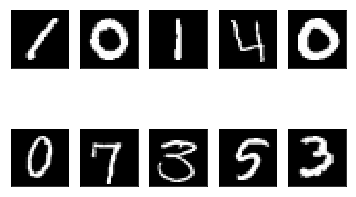

In [4]:
# Display first 10 training images 
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.grid(False)
    image=train.iloc[i].drop("label")
    plt.imshow(image.values.reshape(28,28), cmap=plt.get_cmap('gray'))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [5]:
# Normalize image vectors 
train_X = train.drop("label", axis=1)/255
test_X = test.T/255

# Convert image labels to one hot
labels = train["label"]
one_hot = tf.one_hot(labels, 10, axis=0)
sess = tf.Session()
train_Y = sess.run(one_hot).T
sess.close()

In [6]:

train_X, dev_X, train_Y, dev_Y = train_test_split(train_X, train_Y, test_size=0.1, random_state=1)
train_X = train_X.T 
dev_X = dev_X.T 
train_Y = train_Y.T 
dev_Y = dev_Y.T 

print ("train_X shape: " + str(train_X.shape))
print ("train_Y shape: " + str(train_Y.shape))
print ("dev_X shape: " + str(dev_X.shape))
print ("dev_Y shape: " + str(dev_Y.shape))
print ("test_X shape: " + str(test_X.shape))

train_X shape: (784, 37800)
train_Y shape: (10, 37800)
dev_X shape: (784, 4200)
dev_Y shape: (10, 4200)
test_X shape: (784, 28000)


In [7]:
# Create function to initialize parameters
def initialize_parameters():
    W1 = tf.get_variable("W1", [512,784], initializer = tf.contrib.layers.xavier_initializer(seed = 2020))
    b1 = tf.get_variable("b1", [512,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [10,512], initializer = tf.contrib.layers.xavier_initializer(seed = 2020))
    b2 = tf.get_variable("b2", [10,1], initializer = tf.zeros_initializer())
    parameters = {"W1":W1, "b1":b1, "W2":W2, "b2":b2}
    return parameters

In [8]:
# Create function to implement forward propagation
def forward_propagation(X, parameters):
    W1, b1, W2, b2=  [parameters.get(key) for key in ["W1", "b1", "W2", "b2"]]
    
    Z1 = tf.add(tf.matmul(W1,tf.cast(X,tf.float32)), b1)
    A1 = tf.nn.relu(Z1)
    Z = tf.add(tf.matmul(W2,A1), b2)
    
    return Z

In [9]:
# Create function to implement cost function
def compute_cost(Z, Y):
    logits = tf.transpose(Z)
    labels = tf.transpose(Y)
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    
    return cost 

In [10]:
# Create function to create placeholder
def create_placeholders(n_x, n_y):
    X = tf.placeholder(tf.float32, name="X", shape=[n_x, None])
    Y = tf.placeholder(tf.float32, name="Y", shape=[n_y, None])
    return X, Y

In [11]:
# Create function to implement NN model
def nn_model(train_X, train_Y, dev_X, dev_Y, learning_rate=0.0001):  
    # Build NN graph 
    X, Y = create_placeholders(train_X.shape[0], train_Y.shape[0])
    initial_parameters = initialize_parameters()
    Z = forward_propagation(X, initial_parameters)
    cost = compute_cost(Z, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    # Train NN
    init = tf.global_variables_initializer()
    costs = []

    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(1000):
            _ , epoch_cost = sess.run([optimizer, cost], feed_dict={X: train_X, Y: train_Y})
            
            costs.append(epoch_cost)

        parameters = sess.run(initial_parameters)
        
        # Plot cost by iteration
        plt.plot(np.squeeze(costs))
        plt.ylabel('Cost')
        plt.xlabel('Iteration')
        plt.show()

        # Calculate accuracy on training set and dev set 
        correct_prediction = tf.equal(tf.argmax(Z), tf.argmax(Y))
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

        print("Train Accuracy:", accuracy.eval({X: train_X, Y: train_Y}))
        print("Dev Accuracy:", accuracy.eval({X: dev_X, Y: dev_Y}))
    return parameters

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



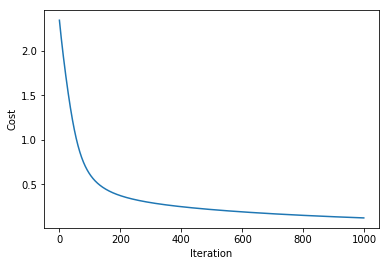

Train Accuracy: 0.96962965
Dev Accuracy: 0.95714283


In [12]:
tf.reset_default_graph() 
parameters = nn_model(train_X, train_Y, dev_X, dev_Y)

In [13]:
# Create function to make predictions
def prediction(test_X, parameters): 
    with tf.Session() as sess:
        Z = forward_propagation(test_X, parameters)
        Y_predicted = tf.argmax(tf.nn.softmax(Z))
        test_Y_predicted = sess.run(Y_predicted)
    return test_Y_predicted

In [14]:
test_Y_predicted = prediction(test_X, parameters)

In [15]:
submission = pd.DataFrame({"ImageId": test.index+1, "Label":test_Y_predicted})
submission.to_csv("digitrecognizer.xlsx", index=False)